In [1]:
import numpy as np
import torch
from torch import nn

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

def simulate_gmm(n, d, r, theta):
    """ Simulate a Gaussian Mixture Model matrix with fixed rank.

    Parameters:
        n (int): Number of rows in the matrix.
        d (int): Number of columns in the matrix.
        r (int): Rank of the low-rank component.
        theta (list of float): Weights for the rank components.
   
    Returns:
        np.ndarray: The simulated matrix X.
    """
   
    # Orthonormal vectors
    A = np.linalg.qr(np.random.randn(d, r))[0].T
    B = np.linalg.qr(np.random.randn(n, r))[0].T
   
    # Random matrix
    Z = np.random.normal(0, scale=np.sqrt(1/d), size=(d, n))

    # Low rank X
    X = np.sum([
        theta[i] * np.outer(A[i], B[i]) for i in range(r)
    ], axis=0) + Z
   
    return X, B, A
    
def marcenko_pastur_density(lambda_vals, gamma):
    """Theoretical probability density."""
    
    lambda_plus = (1 + np.sqrt(gamma))**2
    lambda_minus = (1 - np.sqrt(gamma))**2
    density = np.zeros_like(lambda_vals)
    support = (lambda_vals >= lambda_minus) & (lambda_vals <= lambda_plus)
    density[support] = (1 / (2 * np.pi * gamma * lambda_vals[support])) * \
                       np.sqrt((lambda_plus - lambda_vals[support]) * (lambda_vals[support] - lambda_minus))
    return density

/root/highdim/.env/lib/python3.12/site-packages/numpy/_core/getlimits.py:548: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [159]:
n = 500  # Number of rows
d = 1500  # Number of columns
r = 3     # Rank of the low-rank component
theta = np.array([2., 1.18, 1.0])  # Weights

X, _, _ = simulate_gmm(n, d, r, theta * 2)
X = X.T
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Activation function
sigma = np.arctan

# Weights
W0 = np.random.randn(d, d)
W1 = np.random.randn(d, d)

# Output of each layer
X0 = X.copy()
X1 = sigma(X0 @ W0)
X2 = sigma(X1 @ W1)

# Row-wise covariance
K0 = np.cov(X0)
K1 = np.cov(X1)
K2 = np.cov(X2)

# Eigendecomposition
vals0, vecs0 = np.linalg.eig(K0)
vals1, vecs1 = np.linalg.eig(K1)
vals2, vecs2 = np.linalg.eig(K2)

# 10th layers
X10 = X0.copy()
for i in range(10):
    Wi = np.random.randn(d, d)
    X10 = sigma(X10 @ Wi)

K10 = np.cov(X10)
vals10, vecs10 = np.linalg.eig(K10)

# Theory
gamma = n/d
lambda_vals = np.linspace(0, (1 + np.sqrt(gamma))**2, 1000)
density = marcenko_pastur_density(lambda_vals, gamma)

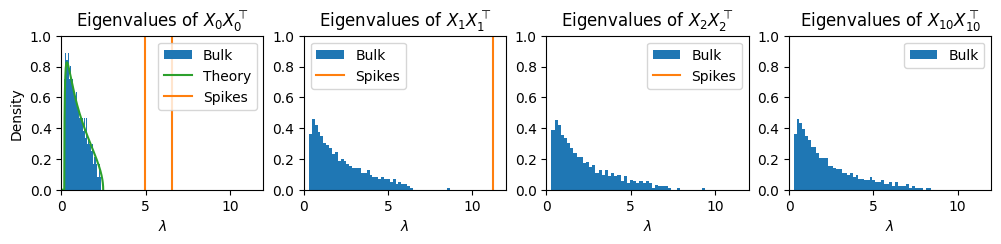

In [160]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2))

# Eigenspectrum
nbins = 50
bins = np.linspace(vals0[3:].min(), vals0[3:].max(), nbins)

axes[0].hist(vals0[3:], bins=bins, density=True, label='Bulk')
axes[0].plot(lambda_vals, density, label=f'Theory', color='C2')
axes[0].axvline(vals0[0], color='C1', label='Spikes')
axes[0].axvline(vals0[1], color='C1')
axes[0].axvline(vals0[2], color='C1')

bins = np.linspace(vals1[2:].min(), vals1[2:].max(), nbins)
axes[1].hist(vals1[2:], bins=bins, label='Bulk', density=True)
axes[1].axvline(vals1[0], color='C1', label='Spikes')
axes[1].axvline(vals1[1], color='C1')


bins = np.linspace(vals2[1:].min(), vals2[1:].max(), nbins)
axes[2].hist(vals2[1:], bins=bins, label='Bulk', density=True)
axes[2].axvline(vals2[0], color='C1', label='Spikes')

bins = np.linspace(vals10.min(), vals10.max(), nbins)
axes[3].hist(vals10, bins=bins, label='Bulk', density=True)
#axes[3].axvline(valsi[0], color='C1', label='Spikes')

titles = [
    r"Eigenvalues of $X_0 X_0^{\top}$",
    r"Eigenvalues of $X_1 X_1^{\top}$",
    r"Eigenvalues of $X_2 X_2^{\top}$",
    r"Eigenvalues of $X_{10} X_{10}^{\top}$"
]

for i in range(4):
    axes[i].legend()
    axes[i].set_xlim(-1e-4, 12)
    axes[i].set_ylim(0, 1.)
    axes[i].set_title(titles[i])
    axes[i].set_xlabel(r"$\lambda$")

axes[0].set_ylabel("Density");

In [6]:
# Initialize
# n = 500 
# d = 1500

n = 2500 
d = 7500

r = 1
gamma = n/d
sigma = np.tanh
theta = np.array([2.5])

# Simulate X
X0, b, a = simulate_gmm(n, d, r, theta)
X0 = X0.T
X0 = (X0 - X0.mean(axis=0)) / X0.std(axis=0)

K0 = np.cov(X0)
vals, vecs = np.linalg.eig(K0)
similarity = np.zeros((4, 9))

similarity[:, 0] = np.abs(vecs[:, 0].real @ b[0])**2

ind = 0
for d_hidden in [2048//2, 4096//2, 8192//2, 10240//2]:
    Wi = np.random.randn(d, d_hidden)
    Xi = X0.copy()
    for i in tqdm(range(8), total=8):
    
        Xi = sigma(Xi @ Wi)
       
        Ki = np.cov(Xi)
        vals, vecs = np.linalg.eig(Ki)
       
        inds = np.argsort(vals)[::-1]
        vals = vals[inds].real
        vecs = vecs[:, inds].real
    
        similarity[ind, i+1] = np.abs(vecs[:, 0] @ b[0])**2
       
        Wi = np.random.randn(d_hidden, d_hidden)
    ind += 1

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

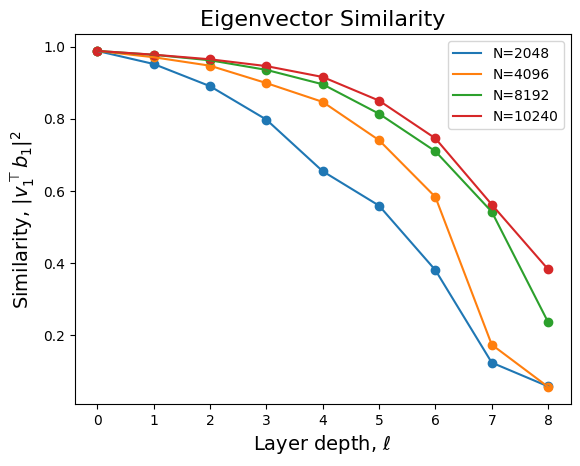

In [7]:
labels = ["N=2048", "N=4096", "N=8192", "N=10240"]

for sims, lab in zip(similarity, labels):
    plt.plot(sims, label=lab)
    plt.scatter(np.arange(9), sims)

plt.xlabel(r"Layer depth, $\ell$", size=14)
plt.ylabel(r"Similarity, $|v_1^\top b_1|^2$", size=14)
plt.title("Eigenvector Similarity", size=16)
plt.legend()

In [13]:
class NN0(nn.Module):
    def __init__(self, d, N):
        super().__init__()
        
        self.W0 = nn.Parameter(torch.randn(d, N))
        self.W1 = nn.Parameter(torch.randn(N, N))
        self.W2 = nn.Parameter(torch.randn(N, N))
        self.W3 = nn.Parameter(torch.randn(N, N))
        self.W4 = nn.Parameter(torch.randn(N, N))
        self.W5 = nn.Parameter(torch.randn(N, N))
        self.W6 = nn.Parameter(torch.randn(N, N))
        self.W7 = nn.Parameter(torch.randn(N, N))
        self.W8 = nn.Parameter(torch.randn(N, 1))
        
        self.sigma = torch.tanh

        self.c = 1#(1/N)**(0.5)
        
    def forward(self, X):
        Xout = self.c * self.sigma((X @ self.W0))
        for W in [self.W1, self.W2, self.W3, self.W4, self.W5, self.W6, self.W7, self.W8]:
            Xout = self.c * self.sigma(Xout @ W)    
        return Xout
    
    def get_alignments(self, X, b):
        Xi = X.copy()
        alignments = np.zeros(8)
        i = 0
        for W in [self.W0, self.W1, self.W2, self.W3, self.W4, self.W5, self.W6, self.W7]:
            Xi = Xi @ W.detach().numpy()
            Ki = np.cov(Xi)
            vals, vecs = np.linalg.eig(Ki)
            alignments[i] = np.abs(vecs[:, 0] @ b[0])**2
            i += 1

        return alignments

In [28]:
n = 500 
d = 1500

r = 1
gamma = n/d
sigma = np.tanh
theta = np.array([1.8])  # Weights

# Simulate X
X, b, a = simulate_gmm(n, d, r, theta)
X = X.T
X = (X - X.mean(axis=0)) / X.std(axis=0)
X0 = torch.from_numpy(X).float()
y = torch.from_numpy(b[0]).float()

In [29]:
T = [0, 10, 20, 50]
alignments = np.zeros((len(T), 8))

loss_fn = nn.MSELoss()
lr = 2e-3

model = NN0(d, d)
opt = torch.optim.SGD(model.parameters(), lr=lr)
ind = 0
for i in tqdm(range(51), total=51):
    
    if i in T:
        alignments[ind] = model.get_alignments(X, b)
        ind += 1
        
    ypred = model(X0)
    loss = loss_fn(y, ypred[:, 0])
    loss.backward()
    print("Loss: ", float(loss), end="\r")
    
    opt.step()
    opt.zero_grad()

  0%|          | 0/51 [00:00<?, ?it/s]

Loss:  0.9859393835067749

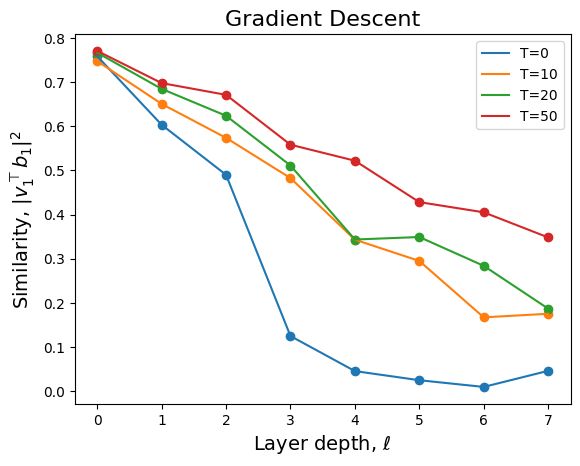

In [30]:
labels = [f"T={i}" for i in T]

for i in range(len(alignments)):
    plt.plot(alignments[i], label=labels[i])
    plt.scatter(np.arange(8), alignments[i])

plt.title("Gradient Descent", size=16)
plt.xlabel(r"Layer depth, $\ell$", size=14)
plt.ylabel(r"Similarity, $|v_1^\top b_1|^2$", size=14)
plt.legend();

In [504]:
from torch.optim.lr_scheduler import LambdaLR

class NN1(nn.Module):
    def __init__(self, d, N):
        super().__init__()
        W = torch.randn(d, N)
        #W = W / torch.norm(W)
        self.W = nn.Parameter(W)

        a = torch.randn(N)
        #a = a / torch.norm(a)
        self.a = a
        self.sigma = torch.erf#torch.tanh

        self.c = (1/N)**(0.5)
        
    def forward(self, X):
        return self.c * (self.sigma((X @ self.W)) @ self.a)

In [505]:
#n = 200   # Number of rows
#d = 1600  # Number of columns

n = 200   # Number of rows
d = 1600  # Number of columns
N = 400

n = int(n * 4)
d = int(d * 4)
N = int(N * 4)

r = 1     # Rank of the low-rank component

theta = np.array([1.8])

X, b, a = simulate_gmm(n, d, r, theta )
X = X.T
X = (X - X.mean(axis=0)) / X.std(axis=0)
X0 = torch.from_numpy(X).float()
y = torch.from_numpy(b[0]).float()

In [506]:
model = NN1(d, N)

lr = 2.

opt = torch.optim.SGD(model.parameters(), lr=lr)

def lr_lambda(iteration):
    return 2.0 / (iteration + 1)  # +1 to avoid division by zero at the start

scheduler = LambdaLR(opt, lr_lambda)


ind = 0
for i in tqdm(range(21), total=21):

    ypred = model(X0)
    loss = loss_fn(y, ypred)
    loss.backward()
    #print("Loss: ", float(loss))#, end="\r")
    
    opt.step()
    opt.zero_grad()
    scheduler.step()

  0%|          | 0/21 [00:00<?, ?it/s]

In [507]:
Xi = model.sigma(X0 @ model.W).detach().numpy()
K = np.cov(Xi)
vals, vecs = np.linalg.eig(K)

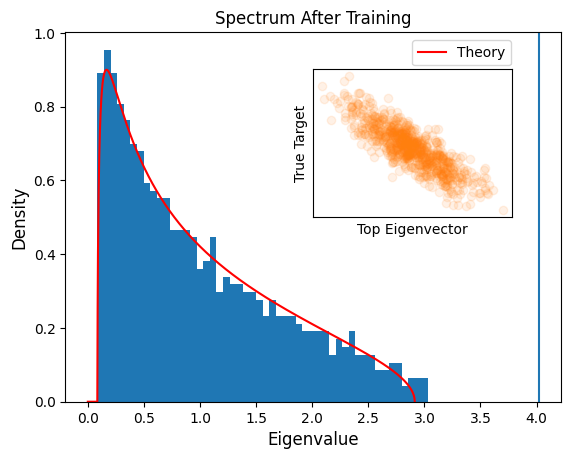

In [508]:
# Theory
gamma = n/N
lambda_vals = np.linspace(0, (1 + np.sqrt(gamma))**2, 1000)
density = marcenko_pastur_density(lambda_vals, gamma)


fig, axes = plt.subplots(nrows=1, ncols=1)
axes = [axes]

axes[0].hist(vals.real[1:], bins=50, density=True)
axes[0].plot(lambda_vals, density, color='red', label='Theory')

axes[0].axvline(vals[0].real, color='C0')

ax = axes[0].inset_axes([.5, .5, .4, .4])
ax.scatter(vecs[:, 0], b[0], color='C1', alpha=.1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("Top Eigenvector")
ax.set_ylabel("True Target")
axes[0].legend(loc=[.7, .91])
axes[0].set_ylabel("Density", size=12)
axes[0].set_xlabel("Eigenvalue", size=12)
axes[0].set_title(r"Spectrum After Training");

In [823]:
from torch.optim.lr_scheduler import LambdaLR

class NN1(nn.Module):
    def __init__(self, d, N):
        super().__init__()
        W = torch.randn(d, N)
        W = (W-W.mean())/W.std()
        W = W * (1/d)
        self.W = nn.Parameter(W)

        a = torch.randn(N)
        #a = a / torch.norm(a)
        self.a = a
        
        self.sigma = torch.tanh

        self.c = (1/N)**(0.5)
        self.bias = nn.Parameter(torch.randn(1))
        
    def forward(self, X):
        return (self.c * (self.sigma((X @ self.W)) @ self.a)) + self.bias

In [825]:
beta_true = torch.randn(d)
beta_true = (beta_true-beta_true.mean())/beta_true.std()
beta_true = beta_true / torch.norm(beta_true)

In [834]:
sigma_true = torch.nn.Softplus()
d = 2048
N = 1024
d = d//2
N = N//2

alignment = np.zeros((3, 21))

ni = 0
for n in [1024, 2048, 4096]:

    # Simulate
    n = n//2
  
    # Train
    error = torch.randn(n) * .1
    X = torch.randn(n, d)
    y = sigma_true(X @ beta_true) + error
    
    # Test
    error = torch.randn(n) * .1
    X_test = torch.randn(n, d)
    y_test = sigma_true(X_test @ beta_true) + error

    # Init model
    model = NN1(d, N)
    lr = 0.2 / np.sqrt(N)
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    
    # Alignment
    Xi = model.sigma(X_test @ model.W).detach().numpy()
    K = (1/N) * (Xi @ Xi.T)
    vals, vecs = np.linalg.eig(K)
    alignment[ni, 0] = np.abs(
        (vecs[:, 0] @ (y_test.numpy()/ np.linalg.norm(y_test.numpy())))
    )**2
    
    # Training
    ind = 0
    for i in tqdm(range(20), total=20):
    
        ypred = model(X)
        loss = loss_fn(y, ypred)
        loss.backward()
        print("Loss: ", float(loss), end="\r")
        
        opt.step()
        opt.zero_grad()
    
        # Aligment
        Xi = model.sigma(X_test @ model.W).detach().numpy()
        K = (1/N) * (Xi @ Xi.T)
        vals, vecs = np.linalg.eig(K)
        alignment[ni, i+1] = np.abs(
            (vecs[:, 0] @ (y_test.numpy()/ np.linalg.norm(y_test.numpy())))
        )**2

    ni += 1

  0%|          | 0/20 [00:00<?, ?it/s]

Loss:  0.34808659553527834

  0%|          | 0/20 [00:00<?, ?it/s]

Loss:  0.23748828470706943

  0%|          | 0/20 [00:00<?, ?it/s]

Loss:  0.45136797428131104

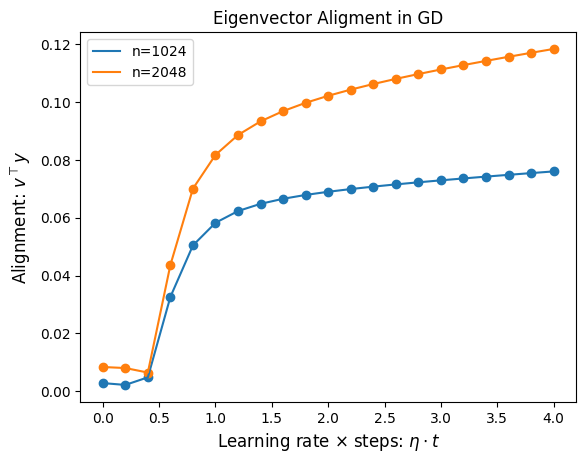

In [846]:
labels = ["n=1024", "n=2048"]
ind = 0
for i in alignment[1:]:
    plt.plot(np.arange(21) * 0.2, i, label=labels[ind])
    plt.scatter(np.arange(21) * 0.2, i)
    ind += 1

plt.title("Eigenvector Aligment in GD")
plt.xlabel(r"Learning rate $\times$ steps: $\eta \cdot t$", size=12)
plt.ylabel(r"Alignment: $v^\top y$", size=12)
plt.legend();